# Proto2 Winter Analysis Splines

### import necessary modules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statistics
import math

#### import functions I've written and that are locally stored

In [2]:
import sys
sys.path.append("/home/ehojeily/scripts/functions/")
from calibrate import calibrate
from generate_coefficients import generate_coefficients
from graph import norm_graph

### import proto 2 data 

In [3]:
proto2_despiked = pd.read_csv('/data/aq/nyserda/proto2/extended_analysis_data/despiked_proto2_ext.csv')
proto2_despiked = proto2_despiked.drop('Unnamed: 0',1)

In [4]:
proto2_despiked['datetime'] = pd.to_datetime(proto2_despiked['datefield'],format='%Y-%m-%d %H:%M:%S')
proto2_despiked = proto2_despiked.set_index('datetime')
houravg = proto2_despiked.resample('60min').mean()

In [5]:
houravg['time'] = houravg.reset_index().index # hours since deployment

### import dec reference data 

In [6]:
path_epa='/data/aq/dec/queens/epa_api/'
epa_filepaths = []
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)

#epa_from_files = (pd.read_csv(f,encoding='cp1252') for f in epa_filepaths) # https://stackoverflow.com/questions/33819557/unicodedecodeerror-utf-8-codec-while-reading-a-csv-file
epa_from_files = (pd.read_csv(f,encoding='cp437') for f in epa_filepaths) # https://stackoverflow.com/questions/9233027/unicodedecodeerror-charmap-codec-cant-decode-byte-x-in-position-y-character

epa_df = pd.concat(epa_from_files) 

In [7]:
#epa_df = epa_df.drop(columns=['Unnamed: 0'])

##### .. correct CO and ozone concentrations and calculate NO

In [8]:
epa_df['Carbon monoxide']=epa_df['Carbon monoxide']*1000
epa_df['Ozone']=epa_df['Ozone']*1000
epa_df['Nitrogen oxide']=epa_df['Oxides of nitrogen (NOx)']-epa_df['Nitrogen dioxide (NO2)']

In [9]:
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))
#epa_table={42101:'Carbon monoxide',44201:'Ozone',42601:'Oxides of nitrogen (NOx)',42602:'Nitrogen dioxide (NO2)',88101:'PM2.5 - Local Conditions'}
epa_df.rename(columns={'PM2.5 - Local Conditions': 'PM2.5', 'Nitrogen dioxide (NO2)': 'NO2','Carbon monoxide':'CO', 
                       'Oxides of nitrogen (NOx)':'NOx','Ozone':'O3','Nitrogen oxide':'NO'},inplace=True)

## preparing data 

### we need to correct data for timezones and NaN values

#### .. timezone corrections

In [10]:
houravg = houravg.tz_localize(tz='UTC') # proto 2 is in UTC

In [11]:
epa_df = epa_df.tz_localize(tz='EST') # DEC is in est
epa_df = epa_df.tz_convert('UTC') # convert to UTC

#### .. match epa to proto2

In [12]:
# keep only DEC data that matches Proto2 data 
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;

#### .. choose only training period data 

In [13]:
#training_period_month = 'June'
training_period_month = 'Oct'

In [14]:
if training_period_month == 'Oct':
    DEC_training_month = epa_df_matching_proto2.loc['2021-10-01 00:00:00+00:00':'2021-10-31 23:00:00+00:00']
    training_dates = pd.read_csv('/home/ehojeily/scripts/training_dates_oct.txt')
    testing_dates = pd.read_csv('/home/ehojeily/scripts/testing_dates_oct.txt')
if training_period_month == 'June':
    DEC_training_month = epa_df_matching_proto2.loc['2021-06-01 00:00:00+00:00':'2021-06-30 23:00:00+00:00']
    testing_dates = pd.read_csv('/home/ehojeily/scripts/testing_dates_june.txt')
    training_dates = pd.read_csv('/home/ehojeily/scripts/training_dates_june.txt')  

proto2= houravg.loc[DEC_training_month.index]

## .. calculate what percentage of data for each pollutant contains a NaN value...

In [15]:
data = DEC_training_month.columns
data = data.drop(['date'])
for col in data:
    print(col, ' percent NaN = ', ((DEC_training_month[col].isna().sum()/len(DEC_training_month))*100).round(2),'%')

PM2.5  percent NaN =  0.13 %
NO2  percent NaN =  4.03 %
CO  percent NaN =  2.02 %
NOx  percent NaN =  4.03 %
O3  percent NaN =  1.34 %
NO  percent NaN =  4.03 %


#### .. remove NaN from DEC and reindex to match proto2

In [16]:
DEC_training_month = DEC_training_month.dropna(axis=0)
proto2_match2DEC = proto2.loc[proto2.index.isin(DEC_training_month.index)]
proto2_match2DEC;

### data are prepped! 

## Generate and Evaluate Regression Coefficients Using Fixed Random Sampling Method

### training and testing period dates are randomly determined but are not overlapping (meaning a date cannot be within the training and testing period)

### apply calibration

In [17]:
epa_table={42101:'CO',44201:'O3',42601:'NO',42602:'NO2',88101:'PM2.5'}
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}

In [18]:
coefficient_dict = {} 
pvalue_dict = {} 
Bcoefficient_dict = {} 
Bpvalue_dict = {} 
modified_training_input_dict = {}
BIC_gas_model_dict = {}
post_opt_model_rmse_dict= {}


In [19]:
training_dates.index

RangeIndex(start=0, stop=344, step=1)

start by focusing on ozone

Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  Thigh
Model #  1
removed ...  Tlow
Model #  2
Done


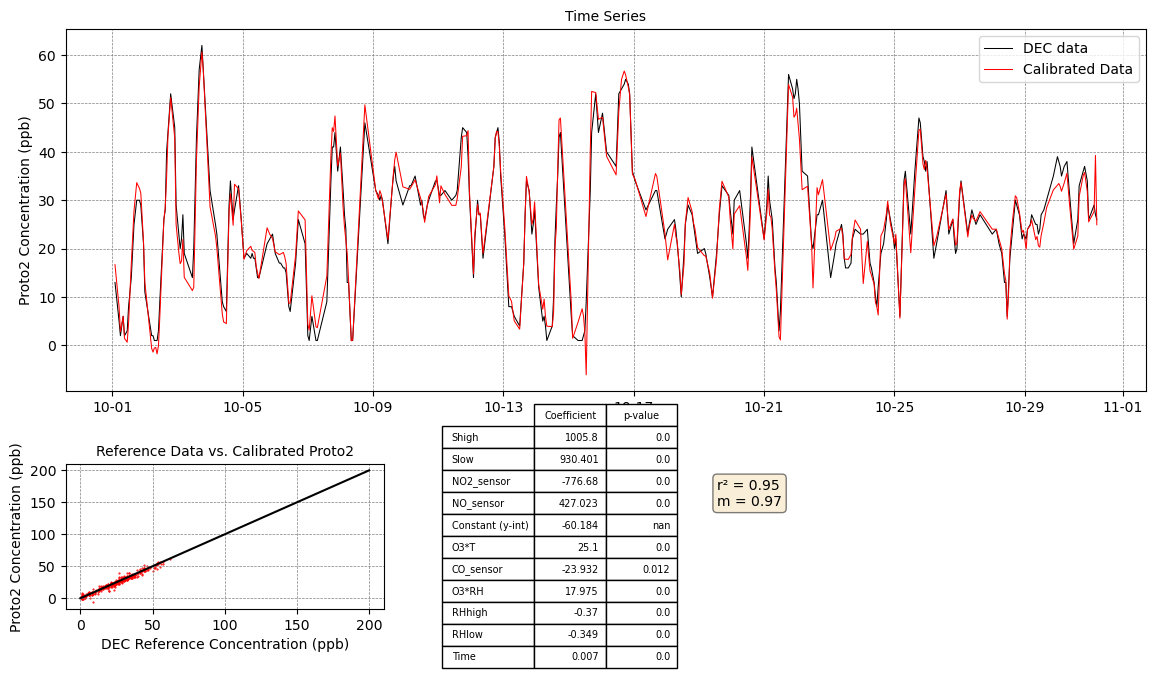

R-squared trainng =  0.9454435064854901
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  Tlow
Model #  1
removed ...  Thigh
Model #  2
Done


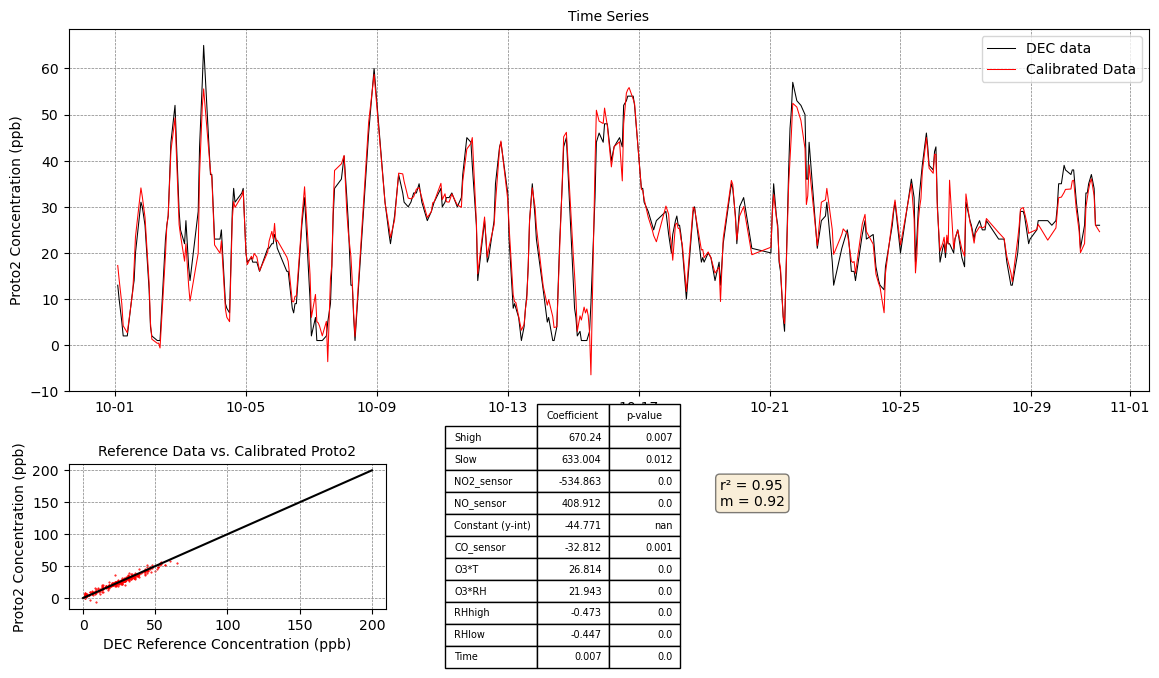

R-squared trainng =  0.9471879662976674
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  Tlow
Model #  1
removed ...  Thigh
Model #  2
removed ...  CO_sensor
Model #  3
Done


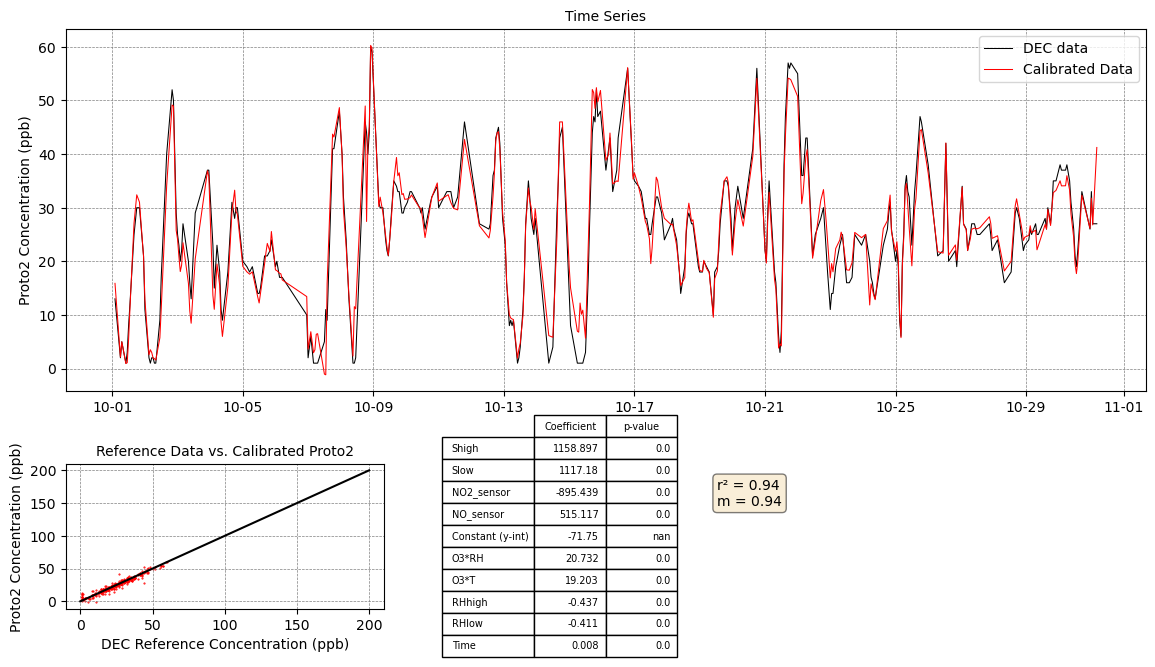

R-squared trainng =  0.9530701727587121
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  Tlow
Model #  1
Done


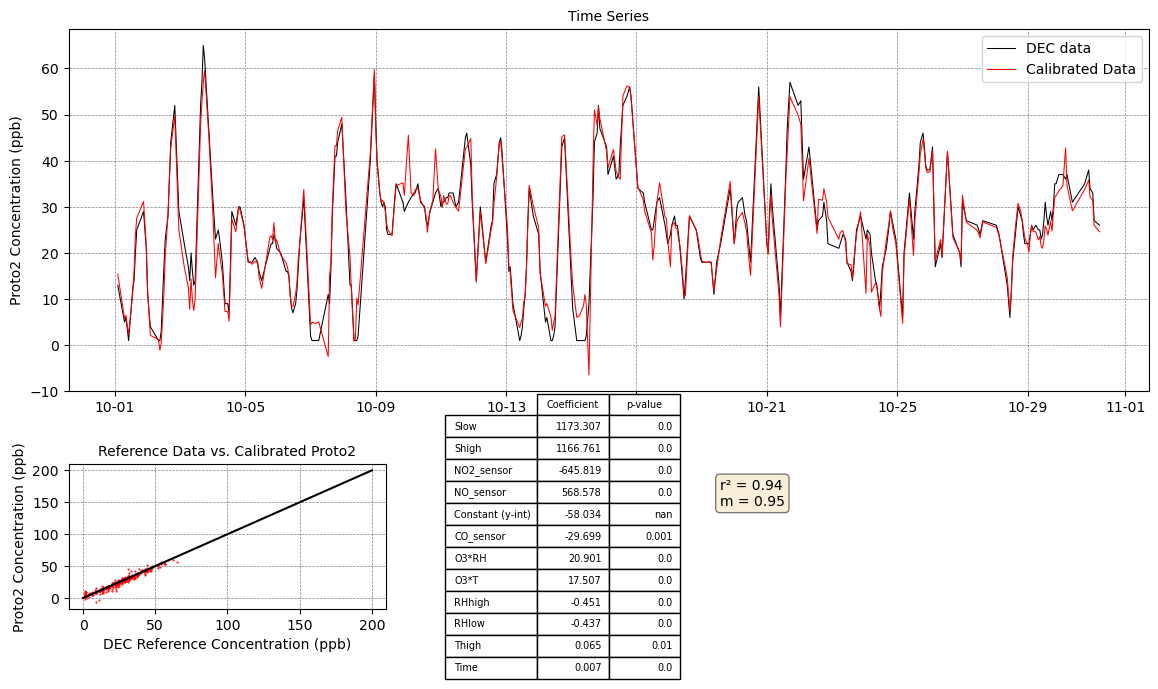

R-squared trainng =  0.9549522908585646
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  Thigh
Model #  1
removed ...  Tlow
Model #  2
Done


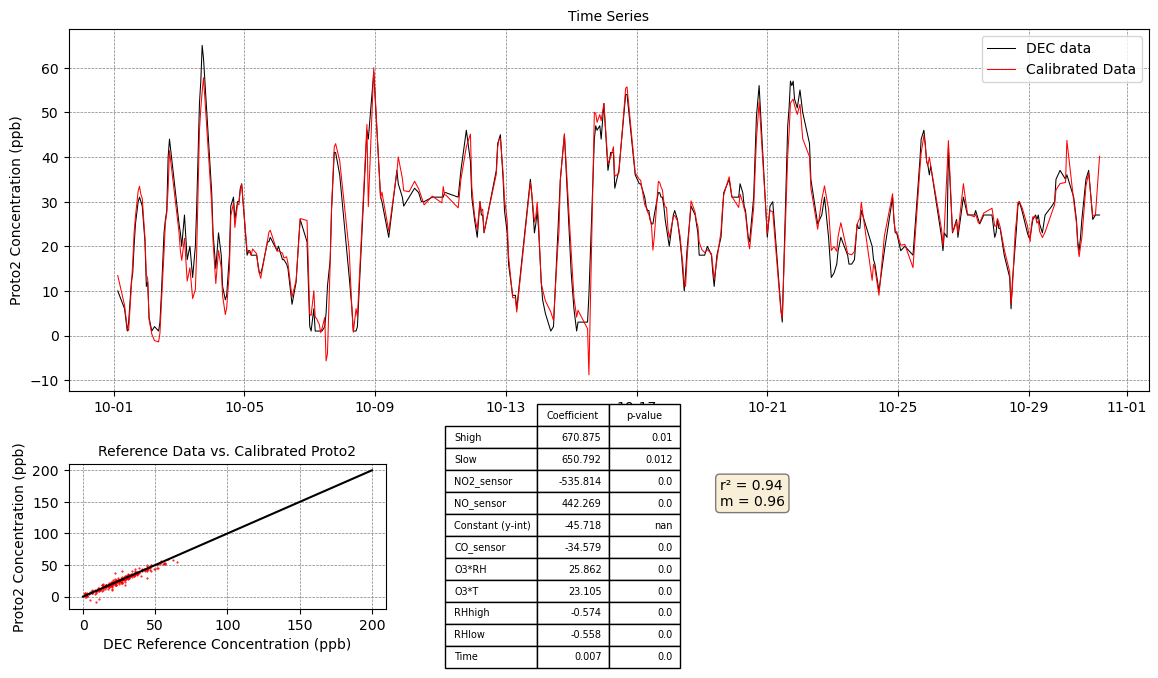

R-squared trainng =  0.9575752116608117
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  Thigh
Model #  1
removed ...  Tlow
Model #  2
Done


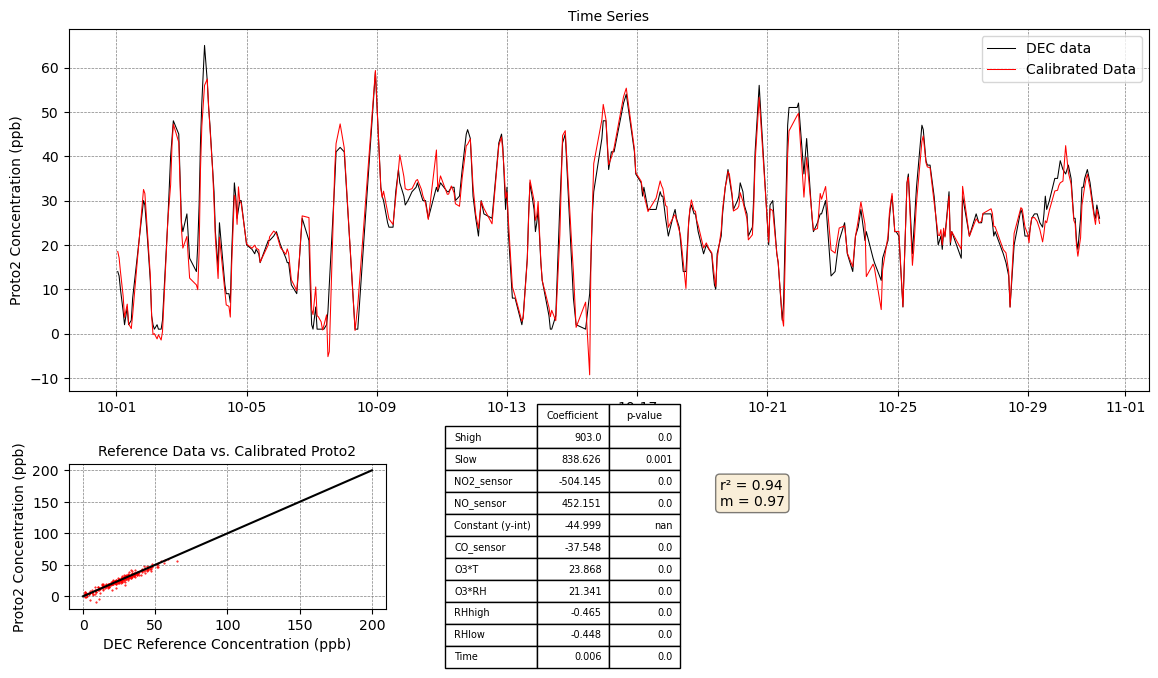

R-squared trainng =  0.9514507862520427
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  O3*T
Model #  1
Done


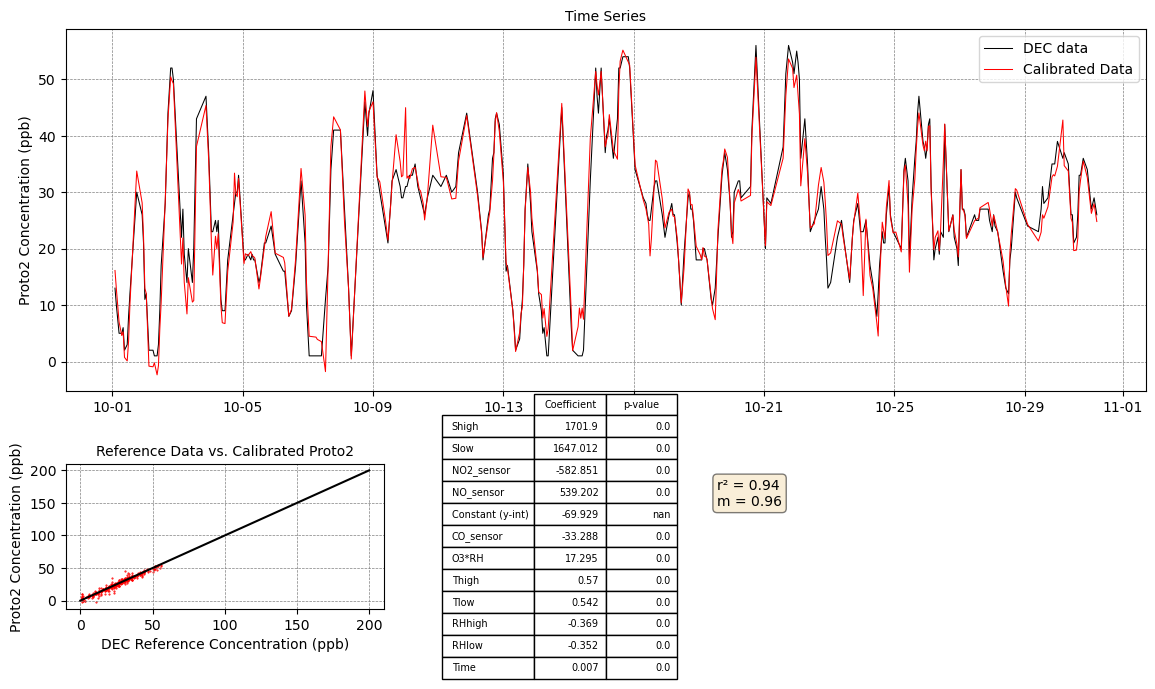

R-squared trainng =  0.9539723615915543
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  CO_sensor
Model #  1
removed ...  Tlow
Model #  2
removed ...  Thigh
Model #  3
Done


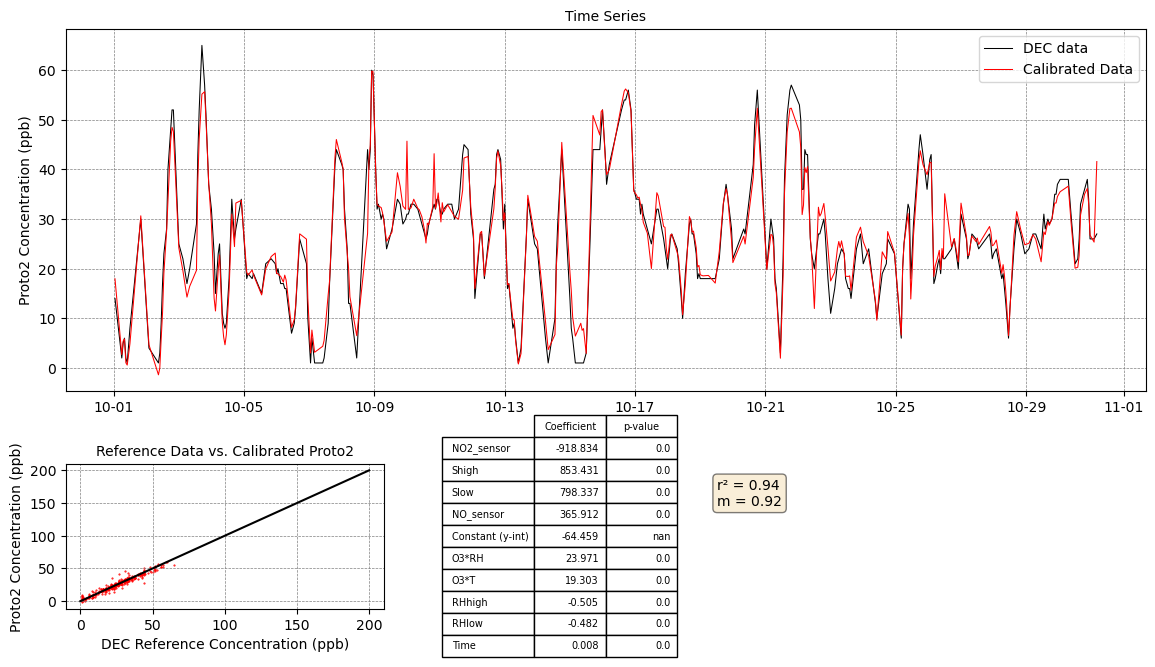

R-squared trainng =  0.957979450165711
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  Thigh
Model #  1
removed ...  CO_sensor
Model #  2
Done


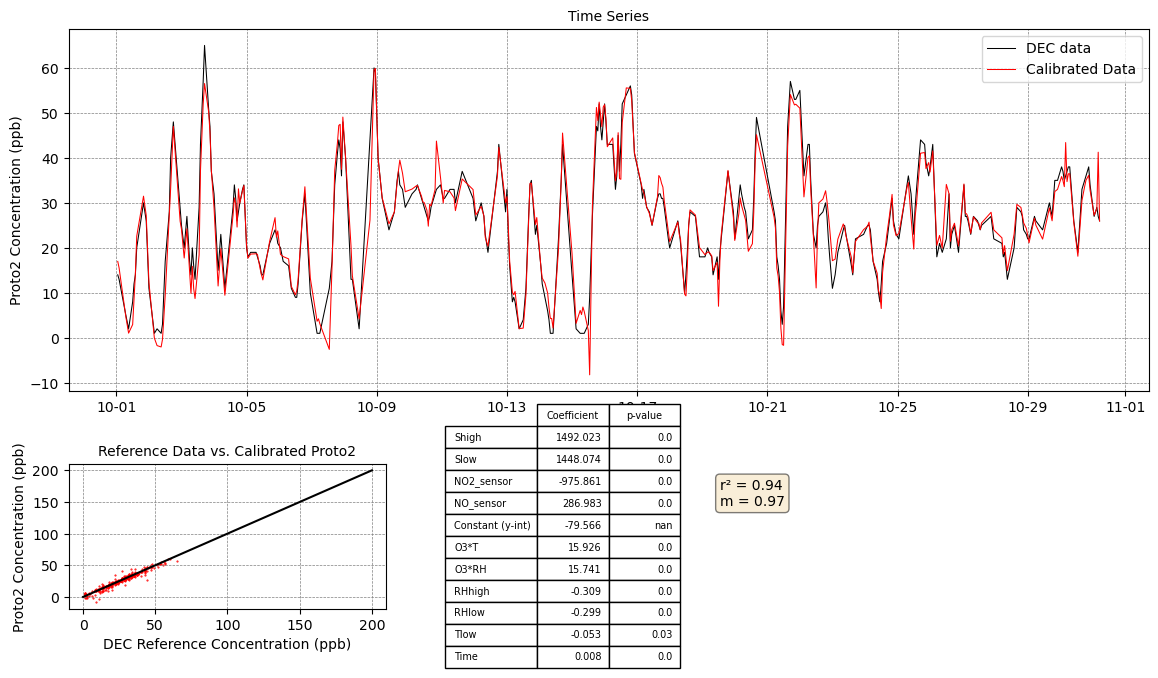

R-squared trainng =  0.9588781213007823
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  Thigh
Model #  1
Done


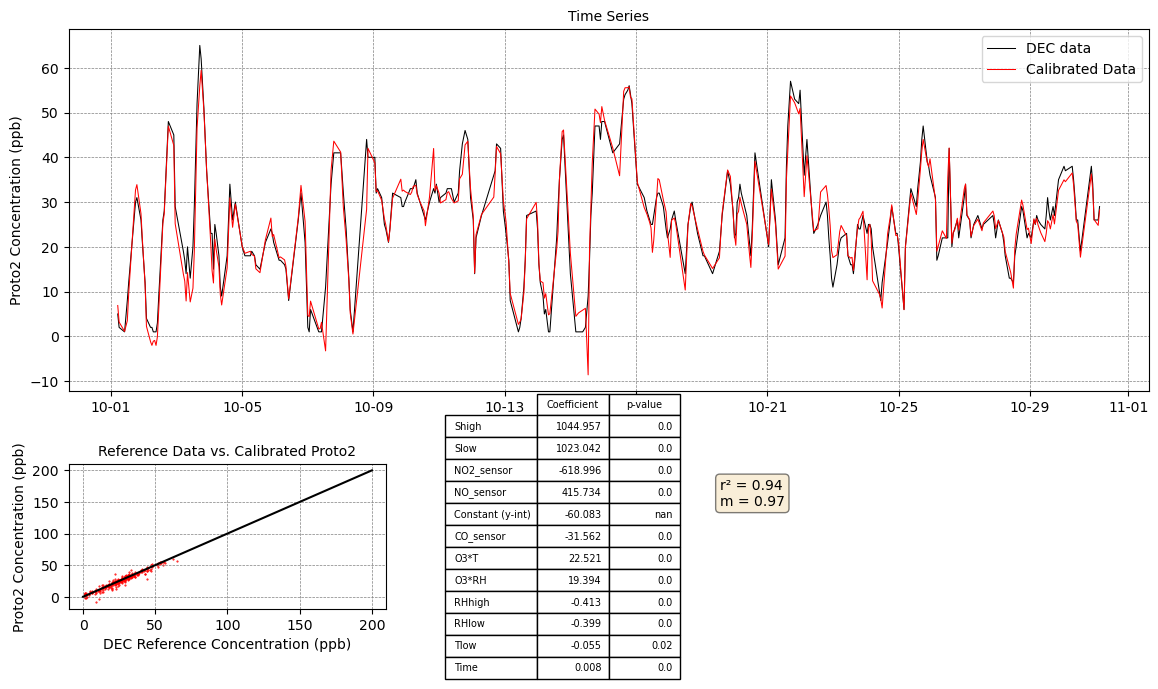

R-squared trainng =  0.9617294545073434
Working on ... O3
Predictors before =  Index(['Tlow', 'Thigh', 'RHlow', 'RHhigh', 'Shigh', 'Slow', 'Time',
       'NO2_sensor', 'NO_sensor', 'CO_sensor', 'O3*RH', 'O3*T'],
      dtype='object')
Optimizing ... 
removed ...  O3*T
Model #  1
Done


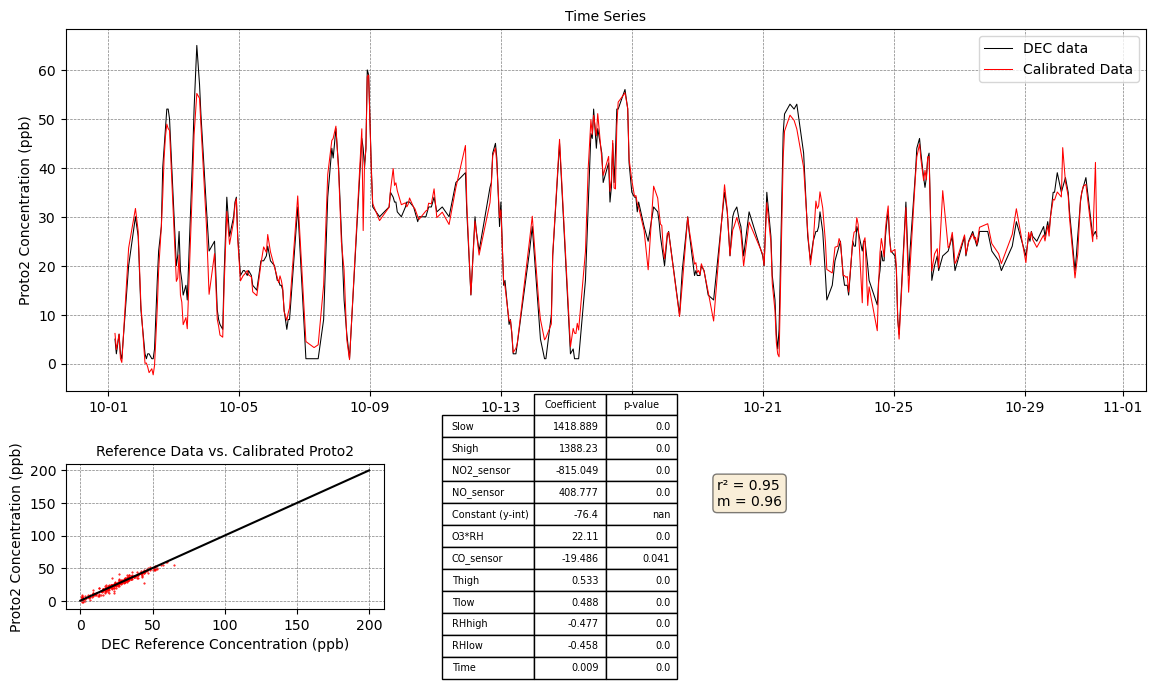

R-squared trainng =  0.9517255815833144


In [21]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for n in range(11):
    var_id = 44201
    dates = pd.concat([DEC_training_month,proto2_match2DEC],axis=1) # creating dataframe of just september dates
    training_dates = dates.sample(frac=0.5) # randomly select half of the data 
    testing_dates = (dates.copy()).loc[~dates.copy().index.isin(training_dates.index)] # selecting data not included in previous random selection aka remaining dates

    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    epa_concentration_field=DEC_training_month[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    
    # Temp Hinge
    medianT = combined_df['temp_sht31_degC'].median()
    combined_df.loc[combined_df['temp_sht31_degC'] <= medianT, 'Tlow'] = 1
    combined_df.loc[combined_df['temp_sht31_degC'] > medianT, 'Tlow'] = 0
    combined_df.loc[combined_df['temp_sht31_degC'] > medianT, 'Thigh'] = 1
    combined_df.loc[combined_df['temp_sht31_degC'] <= medianT, 'Thigh'] = 0
    
    # RH Hinge
    medianRH = combined_df['rh_sht31_percent'].median()
    combined_df.loc[combined_df['rh_sht31_percent'] <= medianRH, 'RHlow'] = 1
    combined_df.loc[combined_df['rh_sht31_percent'] > medianRH, 'RHlow'] = 0
    combined_df.loc[combined_df['rh_sht31_percent'] > medianRH, 'RHhigh'] = 1
    combined_df.loc[combined_df['rh_sht31_percent'] <= medianRH, 'RHhigh'] = 0


    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'
    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    combined_df = combined_df_filtered
    
    print('Working on ...',gname)
    ## adding sensor hinges
    if var_id == 44201 or var_id == 88101 or var_id == 42602 or var_id == 42601 or var_id == 42101:

        ''' SPLINES'''
        # hinges determined by scatterplots, adding cross-sensitivities ... 
        if var_id == 44201: # ozone
            sensor_hinge = 0.020
            combined_df['NO2_voltdiff']=combined_df['NO2_V'].sub(combined_df['NO2_aux_V'],axis=0)
            combined_df['NO_voltdiff']=combined_df['NO_V'].sub(combined_df['NO_aux_V'],axis=0)
            combined_df['CO_voltdiff']=combined_df['CO_V'].sub(combined_df['CO_aux_V'],axis=0)

        combined_df.loc[combined_df[gname+'_voltdiff'] <= sensor_hinge, 'Slow'] = 1
        combined_df.loc[combined_df[gname+'_voltdiff'] > sensor_hinge, 'Slow'] = 0
        combined_df.loc[combined_df[gname+'_voltdiff'] > sensor_hinge, 'Shigh'] = 1
        combined_df.loc[combined_df[gname+'_voltdiff'] <= sensor_hinge, 'Shigh'] = 0
    
        # delineate training and test periods
        combined_df_filtered_training=combined_df.loc[training_dates.index] 
        combined_df_filtered_testing=combined_df.loc[testing_dates.index]

        ## training fields using proto2_QC.csv 
        training_reference_concentrations = combined_df_filtered_training['value']

        training_data = [combined_df_filtered_training['Tlow']*combined_df_filtered_training['temp_sht31_degC'],
                         combined_df_filtered_training['Thigh']*combined_df_filtered_training['temp_sht31_degC'],
                         combined_df_filtered_training['RHlow']*combined_df_filtered_training['rh_sht31_percent'],
                         combined_df_filtered_training['RHhigh']*combined_df_filtered_training['rh_sht31_percent'],
                         combined_df_filtered_training['Shigh']*combined_df_filtered_training[gname+'_voltdiff'],
                         combined_df_filtered_training['Slow']*combined_df_filtered_training[gname+'_voltdiff'],
                         combined_df_filtered_training['time'],combined_df_filtered_training['NO2_voltdiff'],combined_df_filtered_training['NO_voltdiff'], combined_df_filtered_training['CO_voltdiff'],
                         combined_df_filtered_training[gname+'_voltdiff']*combined_df_filtered_training['rh_sht31_percent'],
                         combined_df_filtered_training[gname+'_voltdiff']*combined_df_filtered_training['temp_sht31_degC']] 
                     
        predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time','NO2_sensor','NO_sensor','CO_sensor',gname+'*RH',gname+'*T']
        training_data_input = pd.DataFrame(training_data, index=predictors).transpose()
       
        # testing fields using proto2_QC.csv 
        testing_reference_concentrations = combined_df_filtered_testing['value']
        testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                        combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                        combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                        combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                        combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                        combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                        combined_df_filtered_testing['time'],combined_df_filtered_testing['NO2_voltdiff'],combined_df_filtered_testing['NO_voltdiff'], combined_df_filtered_testing['CO_voltdiff'],
                        combined_df_filtered_testing[gname+'_voltdiff']*combined_df_filtered_testing['rh_sht31_percent'],
                        combined_df_filtered_testing[gname+'_voltdiff']*combined_df_filtered_testing['temp_sht31_degC']] 
                     
                                 
            
        testing_data_input = pd.DataFrame(testing_data, index=predictors).transpose()
        

    print('Predictors before = ', training_data_input.columns)

    print('Optimizing ... ')
    modified_training_data_input = training_data_input.copy()
    modified_testing_data_input = testing_data_input.copy()
    model_dict = {} 
    coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear') # initial calibration 

    for i in range(len(training_data_input)):
        prev_BIC = coefficients['model'].bic
        model_dict[prev_BIC] = modified_training_data_input.columns
        del coefficients['pvalue_dict']['Y-intercept (constant term)']
        highest_pval_pred = max(coefficients['pvalue_dict'], key=coefficients['pvalue_dict'].get)

        if coefficients['pvalue_dict'][highest_pval_pred] > 0.05:
            modified_training_data_input = modified_training_data_input.drop(highest_pval_pred, axis=1)
            modified_testing_data_input = modified_testing_data_input.drop(highest_pval_pred, axis=1)

            opt_coefficients = generate_coefficients(modified_training_data_input,training_reference_concentrations,'linear')
            BIC = opt_coefficients['model'].bic
            print('removed ... ', highest_pval_pred)
            if prev_BIC < BIC-10:
                print('BIC BREAK')
                break
            else:
                print('Model # ',i+1)
                coefficients = opt_coefficients
                continue

        else:
            calibrated_data = calibrate(coefficients['coef_dict'], modified_testing_data_input)
            print('Done')
            break
    
    BIC_gas_model_dict[var_id] = model_dict
    coefficient_dict[var_id] = coefficients['coef_dict']
    pvalue_dict[var_id] = coefficients['pvalue_dict']
    modified_training_input_dict[var_id] = modified_training_data_input

    testing_period = testing_reference_concentrations.index
    norm_graph(var_id,calibrated_data, coefficient_dict[var_id], pvalue_dict[var_id],
                testing_reference_concentrations, testing_period, gname, linear_color='red')


    from sklearn.metrics import mean_squared_error

    rmse = mean_squared_error(testing_reference_concentrations, calibrated_data, squared=False)
    post_opt_model_rmse_dict[BIC] = [rmse,modified_training_data_input.columns.tolist()]

    training_calibrated_data = calibrate(coefficients['coef_dict'], modified_training_data_input)
    n=len(testing_reference_concentrations)
    r2_training=(((n*(training_calibrated_data*training_reference_concentrations).sum())-(training_calibrated_data.sum()*training_reference_concentrations.sum()))\
        /np.sqrt((n*(training_reference_concentrations**2).sum()-(training_reference_concentrations).sum()**2)*\
                 (n*(training_calibrated_data**2).sum()-training_calibrated_data.sum()**2)))**2
    print('R-squared trainng = ',r2_training)

In [22]:
   print('Predictors after = ', training_data_input.columns)
    print('Calibrating using splines ...')
    coefficients = generate_coefficients(modified_training_data_input,training_reference_concentrations,'linear')
    calibrated_data = calibrate(coefficients['coef_dict'], modified_testing_data_input)

    print('Calibrating using simple MLR ...')
    ''' BASIC '''
    ## training fields using proto2_QC.csv 
    Btraining_reference_concentrations = combined_df_filtered_training['value']
    Btraining_data = [combined_df_filtered_training[gname+'_voltdiff'],
                     combined_df_filtered_training['temp_sht31_degC'],
                     combined_df_filtered_training['rh_sht31_percent'],
                     combined_df_filtered_training['time']]      
                     
        
    Btraining_data_input = pd.DataFrame(Btraining_data, index=['Volt Diff','Temp','RH', 'Time']).transpose()
       
    # testing fields using proto2_QC.csv 
    Btesting_reference_concentrations = combined_df_filtered_testing['value']
    Btesting_data = [combined_df_filtered_testing[gname+'_voltdiff']**2,
                    combined_df_filtered_testing['temp_sht31_degC'],
                    combined_df_filtered_testing['rh_sht31_percent'],
                    combined_df_filtered_testing['time']]   
    
    Btesting_data_input = pd.DataFrame(Btesting_data, index=['Volt Diff','Temp','RH','Time']).transpose()
    Bcoefficients = generate_coefficients(Btraining_data_input,training_reference_concentrations,'linear')
    Bcalibrated_data = calibrate(Bcoefficients['coef_dict'], Btesting_data_input)
    Btraining_calibrated_data = calibrate(Bcoefficients['coef_dict'], Btraining_data_input)
    Bcoefficient_dict[var_id] = Bcoefficients['coef_dict']
    Bpvalue_dict[var_id] = Bcoefficients['pvalue_dict']
    B_BIC = Bcoefficients['model'].bic
    model_dict[prev_BIC] = Btraining_data_input.columns


    training_period_month = str(pd.DatetimeIndex(combined_df_filtered_training.index).month_name()[1])
    testing_period = testing_reference_concentrations.index

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    axes[0].scatter(combined_df_filtered_testing[gname+'_voltdiff'], Btesting_reference_concentrations, color='magenta')
    axes[0].set_title('Uncalibrated Data for '+gname)
    axes[0].set_xlabel('Uncalibrated Proto2 '+gname)
    axes[0].set_ylabel('Reference')

    axes[1].scatter(Bcalibrated_data, Btesting_reference_concentrations, color='blue')
    axes[1].set_title('Calibrated Data for '+gname+' (Simple MLR)')
    axes[1].set_xlabel('Calibrated Proto2 '+gname)
    axes[1].set_ylabel('Reference')

    axes[2].scatter(calibrated_data, Btesting_reference_concentrations, color='red')
    axes[2].set_title('Calibrated Data for '+gname+' (Spline MLR)')
    axes[2].set_xlabel('Calibrated Proto2 '+gname)
    axes[2].set_ylabel('Reference')


IndentationError: unexpected indent (3700289314.py, line 2)

# Calibrate winter months

In [23]:
#september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
DEC_wint = epa_df_matching_proto2.loc['2021-12-01 00:00:00+00:00':'2022-04-01 00:00:00+00:00']
proto2_wint = houravg.loc[DEC_wint.index]
proto2_wint_match2DEC = proto2_wint.loc[proto2_wint.index.isin(DEC_wint.index)]
proto2_wint_match2DEC;

In [26]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [44201]:

#get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_wint_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'

    # Temp Hinge
    #medianT = combined_df['temp_sht31_degC'].median()
    combined_df.loc[combined_df['temp_sht31_degC'] <= medianT, 'Tlow'] = 1
    combined_df.loc[combined_df['temp_sht31_degC'] > medianT, 'Tlow'] = 0
    combined_df.loc[combined_df['temp_sht31_degC'] > medianT, 'Thigh'] = 1
    combined_df.loc[combined_df['temp_sht31_degC'] <= medianT, 'Thigh'] = 0
    
    # RH Hinge
    #medianRH = combined_df['rh_sht31_percent'].median()
    combined_df.loc[combined_df['rh_sht31_percent'] <= medianRH, 'RHlow'] = 1
    combined_df.loc[combined_df['rh_sht31_percent'] > medianRH, 'RHlow'] = 0
    combined_df.loc[combined_df['rh_sht31_percent'] > medianRH, 'RHhigh'] = 1
    combined_df.loc[combined_df['rh_sht31_percent'] <= medianRH, 'RHhigh'] = 0
        

    ## adding sensor hinges
    if var_id == 44201 or var_id == 88101 or var_id == 42602 or var_id == 42601 or var_id == 42101:
        ''' SPLINES'''
        # hinges determined by scatterplots, adding cross-sensitivities ... 
        if var_id == 44201: # ozone
            sensor_hinge = 0.020
            combined_df['NO2_voltdiff']=combined_df['NO2_V'].sub(combined_df['NO2_aux_V'],axis=0)
            combined_df['NO_voltdiff']=combined_df['NO_V'].sub(combined_df['NO_aux_V'],axis=0)
            combined_df['CO_voltdiff']=combined_df['CO_V'].sub(combined_df['CO_aux_V'],axis=0)

        if var_id == 88101: # pm25
            sensor_hinge = 10
        if var_id == 42602: # NO2
            sensor_hinge = -0.025
            combined_df['NO_voltdiff']=combined_df['NO_V'].sub(combined_df['NO_aux_V'],axis=0)
            combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        if var_id == 42601: # NO
            sensor_hinge = 0.000
        if var_id == 42101: # CO
            sensor_hinge = 0.15

        combined_df.loc[combined_df[gname+'_voltdiff'] <= sensor_hinge, 'Slow'] = 1
        combined_df.loc[combined_df[gname+'_voltdiff'] > sensor_hinge, 'Slow'] = 0
        combined_df.loc[combined_df[gname+'_voltdiff'] > sensor_hinge, 'Shigh'] = 1
        combined_df.loc[combined_df[gname+'_voltdiff'] <= sensor_hinge, 'Shigh'] = 0
    
        # delineate training and test periods
        combined_df_filtered_testing=combined_df

        ## training fields using proto2_QC.csv 
        training_reference_concentrations = combined_df_filtered_training['value']
        if var_id == 42602: # NO2
       
            # testing fields using proto2_QC.csv 
            testing_reference_concentrations = combined_df_filtered_testing['value']
            testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['time'],combined_df_filtered_testing['NO_voltdiff'],
                            combined_df_filtered_testing['O3_voltdiff'],
                            combined_df_filtered_testing[gname+'_voltdiff']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing[gname+'_voltdiff']*combined_df_filtered_testing['temp_sht31_degC']] 
            
                            
            predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time', 'NO_sensor','O3_sensor',gname+'*RH',gname+'*T']  

        elif var_id == 44201: # O3   
            # testing fields using proto2_QC.csv 
            testing_reference_concentrations = combined_df_filtered_testing['value']
            testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['time'],combined_df_filtered_testing['NO2_voltdiff'],combined_df_filtered_testing['NO2_voltdiff'], combined_df_filtered_testing['CO_voltdiff'],
                            combined_df_filtered_testing[gname+'_voltdiff']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing[gname+'_voltdiff']*combined_df_filtered_testing['temp_sht31_degC']] 
            
            
            predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time', 'NO2_sensor','NO_sensor','CO_sensor',gname+'*RH',gname+'*T']     

        else:
            # testing fields using proto2_QC.csv 
            testing_reference_concentrations = combined_df_filtered_testing['value']
            testing_data = [combined_df_filtered_testing['Tlow']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['Thigh']*combined_df_filtered_testing['temp_sht31_degC'],
                            combined_df_filtered_testing['RHlow']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['RHhigh']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing['Shigh']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['Slow']*combined_df_filtered_testing[gname+'_voltdiff'],
                            combined_df_filtered_testing['time'],
                            combined_df_filtered_testing[gname+'_voltdiff']*combined_df_filtered_testing['rh_sht31_percent'],
                            combined_df_filtered_testing[gname+'_voltdiff']*combined_df_filtered_testing['temp_sht31_degC']] 
                     

            predictors = ['Tlow','Thigh','RHlow','RHhigh','Shigh','Slow','Time',gname+'*RH',gname+'*T']     

        
        testing_data_input = pd.DataFrame(testing_data, index=predictors).transpose()      
        selected_predictors =  modified_training_input_dict[var_id].columns.to_list()
        dropped_predictors = [] 

        for predictor in predictors:
            if predictor not in selected_predictors:
                dropped_predictors.append(predictor)

        #testing_data_input = pd.DataFrame(testing_data, index=all_pred).transpose()
        testing_data_input = testing_data_input.drop(columns=dropped_predictors)

        calibrated_data = calibrate(coefficient_dict[var_id], testing_data_input)

    ''' BASIC '''
       
    # testing fields using proto2_QC.csv 
    Btesting_reference_concentrations = combined_df_filtered_testing['value']
    Btesting_data = [combined_df_filtered_testing[gname+'_voltdiff'],
                    combined_df_filtered_testing['temp_sht31_degC'],
                    combined_df_filtered_testing['rh_sht31_percent'],
                    combined_df_filtered_testing['time']]   
    
    Btesting_data_input = pd.DataFrame(Btesting_data, index=['Volt Diff','Temp','RH','Time']).transpose()
    Bcalibrated_data = calibrate(Bcoefficient_dict[var_id], Btesting_data_input)

    
    training_period_month = str(pd.DatetimeIndex(combined_df_filtered_training.index).month_name()[1])
    testing_period = testing_reference_concentrations.index
    
    
    ''' stats '''
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1)
    b_m = np.polyfit(testing_reference_concentrations,Bcalibrated_data,1)

    n=len(testing_reference_concentrations)
    r2_testing=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    b_r2_testing=(((n*(Bcalibrated_data*testing_reference_concentrations).sum())-(Bcalibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(Bcalibrated_data**2).sum()-Bcalibrated_data.sum()**2)))**2

    from sklearn.metrics import mean_squared_error

    rmse = mean_squared_error(testing_reference_concentrations, calibrated_data, squared=False)
    b_rmse = mean_squared_error(testing_reference_concentrations, Bcalibrated_data, squared=False)



    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    shape, loc = 6, 6

    fig = plt.subplots(figsize=(12,20))
    plt.suptitle(gname+' Regression Calibration Results for '+training_period_month+' 2021 Calibration (Fixed Random Sampling Method)', fontsize=12, x=0.45,y=0.90)

    ''' DEC vs. Calibrated time series plot (top) '''
    time_series = plt.subplot2grid((shape, loc), (0, 0), rowspan=2, colspan=6)
    time_series.set_title('time_series')
    time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.75)
    time_series.plot(testing_period,Bcalibrated_data,label='Simple MLR calibrated', color='red',linewidth=0.75)
    time_series.plot(testing_period,calibrated_data,label='Spline MLR calibrated', color='dodgerblue',linewidth=0.75)

    time_series.legend()  
    time_series.set_title('Time Series', fontsize=10)
    time_series.set_xlabel('Testing Period Date')
    time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 
    time_series.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ''' uncomment to get specific date windows '''
    #time_series.set_xlim([date(2022,1,1), date(2022,2,1)])


    ''' DEC vs. Calibrated trend  plot (bottom left) '''
    data_series = plt.subplot2grid((shape, loc), (2, 0), colspan=2)
    data_series.set_title('data_series')
    data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 300
    if var_id==42602: # N02
        xmax = 60
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    data_series.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    data_series.scatter(testing_reference_concentrations,Bcalibrated_data,color='red',s=0.55)
    data_series.scatter(testing_reference_concentrations,calibrated_data,color='dodgerblue',s=0.55)


    data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
    data_series.text(2.05, 0.90, 'Spline r² = '+str(r2_testing.round(2))+'\nSpline m = '+str(m[0].round(2))+'\nSpline RMSE = '+str(rmse.round(2))+
                     '\n'+'\nSimple r² = '+str(b_r2_testing.round(2))+'\nSimple m = '+str(b_m[0].round(2))+'\nSimple RMSE = '+str(b_rmse.round(2)), 
                     transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    
    ''' Regression Coefficient Table (bottom right) '''
    table_data = pd.DataFrame()
    table_data = table_data.append([coefficient_dict[var_id], pvalue_dict[var_id]],ignore_index=True).transpose().rename(columns = {0:'Coefficient', 1:'p-value'}, 
                                                                                                                                  index={'Y-intercept (constant term)':'Constant (y-int)'}).round(3)
    table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    table = plt.subplot2grid((shape, loc), (2, 2),colspan=2)
    #hide the axes
    table.patch.set_visible(False)
    table.axis('off')
    table.axis('tight')
    regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, colLabels = table_data.columns,loc='center')
    regression_table.scale(0.55,1.5)
    regression_table.set_fontsize(15)
    plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)




    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    axes[0].scatter(combined_df_filtered_testing[gname+'_voltdiff'], Btesting_reference_concentrations, color='magenta')
    axes[0].set_title('Uncalibrated Data for '+gname)
    axes[0].set_xlabel('Uncalibrated Proto2 '+gname)
    axes[0].set_ylabel('Reference')

    axes[1].scatter(Bcalibrated_data, Btesting_reference_concentrations, color='blue')
    axes[1].set_title('Calibrated Data for '+gname+' (Simple MLR)')
    axes[1].set_xlabel('Calibrated Proto2 '+gname)
    axes[1].set_ylabel('Reference')

    axes[2].scatter(calibrated_data, Btesting_reference_concentrations, color='red')
    axes[2].set_title('Calibrated Data for '+gname+' (Spline MLR)')
    axes[2].set_xlabel('Calibrated Proto2 '+gname)
    axes[2].set_ylabel('Reference')


    fig.tight_layout()


KeyError: 44201

In [ ]:
medianT

25.468888857661707

In [ ]:
combined_df_filtered_testing['Thigh'].sum()

3.0